# Upper troposphere wind field and geopotential height field (200 hPa) for the DJF seasonal climatology and regression fields between IPO, ENSO and the dynamic variables.

Figure 7. Simulated DJF 200 hPa horizontal winds (vectors) and geopotential height (contours) from iCAM5 plotted as (a) climatology (1880 – 2000 CE) and regressed against (b) IPO and (c) the ENSO. Contour interval for z-values is (a) 50 m and (b-c) 8 m per unit std. dev., respectively. Scaling vectors for wind field are shown above each plot. The core region of the Walker circulation (via ω500) response to ENSO and IPO indices is outlined as a dashed box in b, c.

# Preamble

In [1]:
# ---------------------------- LIBRARIES
# import os.path
import numpy as np
import pandas as pd
import xarray as xr   # use xarray to open data files instead of netCDF4.  It is faster, and easier. And, it keeps my metadata!
import netCDF4 as ncd
from netCDF4 import Dataset
import scipy
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy import signal
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import dask.array as da
from shapely.geometry.polygon import LinearRing
import matplotlib.patches as patches

import proplot as pplt
import cartopy.feature as cf
import matplotlib.colors as mcols
from mpl_toolkits.axes_grid1 import make_axes_locatable

# %matplotlib inline   # This works in jupyter notebooks, otherwise I can't use it. Also, I would need plt.show()

# ---------------------------- IGNORE PLOTTING WARNING

import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# %matplotlib inline   # This works in jupyter notebooks, otherwise I can't use it. Also, I would need plt.show()

# ---------------------------- LOADING FUNCTIONS
def bounds(scalar_fields):
    """
    Get the bounds of a set of scalar_fields
    :param scalar_fields : the scalar field set
    :return: a set of normalized vector field components
    """
    max_bound = -np.inf
    min_bound = np.inf

    for scalar_field in scalar_fields:
        max_lim = np.max(scalar_field)
        min_lim = np.min(scalar_field)
        if max_lim > max_bound:
            max_bound = max_lim
        if min_lim < min_bound:
            min_bound = min_lim

    return np.around(min_bound,2), np.around(max_bound, 2)

def non_time_coords(ds):
    return [v for v in ds.data_vars
            if 'time' not in ds[v].dims]

def drop_non_essential_vars_pop(ds):
    return ds.drop(non_time_coords(ds))  

def drop_all_coords(ds):
    return ds.reset_coords(drop=True)

def geo_loc(target,array):
    return array[np.abs(array - target).argmin()]
# xr.open_mfdataset('*.nc', combine='by_coords', preprocess=drop_all_coords)

def zscr(self):
    return ((self - np.mean(self))/np.std(self))

def fmt(x):
    """
    format a number with one deci or without a deci if ends in zero
    x: float value as input
    return: formatted x value
    """
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return s

#statistical significance for smoothed data, decreased degrees of freedom. Henry He
def t_p_test(x1, x2, lpp): 
    """
    calculate statistical significance of correlation using adjusted degrees of freedom for smoothed data
    also calculates the p value for tx1: population sample
    x2: population sample
    x3: number of smoothing units
    llp: number of years in the smoothing. 
    returns: t statistic and the p value
    
    """
    n = x1.shape[0]                      # ipo_index_had.shape = 130
    df = 2*n/lpp - 2                     # 2*130 / 11 - 2 = 28.889
    r = stats.pearsonr(x1, x2)[0]        # need same shape: pearsonr(ipo_index_had, var[:,0,1])[0]
    error = np.sqrt((1 - r**2) / df)     # sqrt needs np.
    t = r/error                          # float value
    p = stats.t.sf(np.abs(t), df)*2      # calculate p value
    return r, p

# Load data
- ipo time series
- upper level winds
- upper level geostrophic winds.

In [2]:
path = "/network/rit/home/ro553136/orrison/data/CESM/iCAM5/cntl/atm/f09/"
fh_u200 = xr.open_dataset(path + "f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.u200_1850_2013.nc")
fh_v200 = xr.open_dataset(path + "f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.v200_1850_2013.nc")
fh_z200 = xr.open_dataset(path + "f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.z200_1850_2013.nc")

lat = fh_u200.lat
lon = fh_u200.lon
nlat = len(lat)
nlon = len(lon)

# # -------------- SUBSET MODEL DATA, 1880 -- 1999
icam_yrs = np.arange(1880,2000)

icam_u_200djf = fh_u200.u[30:-14].rename('u200')  
icam_v_200djf = fh_v200.v[30:-14].rename('v200')  
icam_z200_djf = fh_z200.Z3[30:-14].rename('z200') 

vars_all = [icam_u_200djf, icam_v_200djf, icam_z200_djf]
climo = [np.mean(vars_all[i], axis=0) for i in range(len(vars_all))] 

In [3]:
# -------------- DETREND, SAVE AS XR, APPLY 11 YR SMOOTHING. DON'T REMOVE MEAN
# detrend data, save as xr, smooth
vars_all_11yr = []
vars_all_dt = []
# for vari in vars_all:
for vari in vars_all:
    vari_dt = np.zeros(vari.shape)
#------------------- detrending all data -------------------
    for i in range(len(lat)):
        for j in range(len(lon)):
            var_tmp = vari[:,i,j]
            # skip missing values - lat/lon points where the nas is identified. relevant for d18o, d18opwt
            nas = np.isnan(vari[:,i,j])
#             vari_dt[:,i,j] = signal.detrend(var_tmp)
            m, b, r_val, p_val, std_err = stats.linregress(vari[:,i,j][~nas].time,vari[:,i,j][~nas])
            x = vari[:,i,j][~nas].time
            trend_line = m*x+b
            vari_detrended = vari[:,i,j][~nas] - (trend_line - np.mean(trend_line))
            vari_dt[:,i,j] = vari_detrended.reindex(time=icam_yrs,fill_value=np.nan)
#------------------- format as an xr Data Array -------------------
    var = xr.DataArray(vari_dt, 
        coords={'time': icam_yrs,'latitude': lat,'longitude': lon}, 
        dims=["time","lat", "lon"], name = vari.name)     
#------------------- set up for smoothing -------------------
    var_11yr = xr.DataArray(np.zeros([len(vari.time), len(lat), len(lon)]), 
        coords={'time': icam_yrs,'latitude': lat,'longitude': lon}, 
        dims=["time","lat", "lon"], name = vari.name)        
#------------------- 11 year smoothing to match TPI -------------------
    nt = len(var.time)
    filter_11yr = 11
    mirror = int((filter_11yr-1)/2) # end point
    copy = np.zeros((nt+2*mirror))
    for i in range(len(lat)):
        for j in range(len(lon)):
            copy[mirror:-mirror] = var[:,i,j].copy()
            copy[0:mirror] = var[1:mirror+1,i,j].copy()[::-1]
            copy[-mirror:] = var[-1-mirror:-1,i,j].copy()[::-1]
            avg_mask_11yr = np.ones(filter_11yr) / np.real(filter_11yr)
            var_11yr[:,i,j] = np.convolve(copy, avg_mask_11yr, 'same')[mirror:-mirror]
    vars_all_dt.append(var)
    vars_all_11yr.append(var_11yr)

# Load ENSO, IPO index


In [4]:
#------------------- ENSO -------------------
pth_hadsst = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_hadenso = xr.open_dataset(pth_hadsst + 'HADOISST_N34_dt_1880_2000.nc', decode_times= True)
enso_index_had = fh_hadenso.n34ind_had

n34ind_djf_had = [np.nanmean(enso_index_had[11+i:14+i],axis=0) for i in range(0,1440,12)]
    # select period only for 1880 -- 1999
n34ind_djf_had_xr = xr.DataArray(n34ind_djf_had, 
    coords={'time': icam_yrs}, 
    dims=["time"])

# #------------------- IPO -------------------
pth_hadsst = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_hadipo = xr.open_dataset(pth_hadsst + 'HADSSTOI_ipoinds_1880_2000.nc', decode_times= True)
ipo_index_had = fh_hadipo.tpi_index_11yr

# Calculate regression of full ts

In [5]:
r_reg_enso = []
p_reg_enso = []
r_reg_ipo = []
p_reg_ipo = []

for vari in vars_all_dt: 
    r_val_enso = xr.DataArray(np.zeros([len(lat), len(lon)]), 
        coords={'latitude': lat,'longitude': lon}, 
        dims=["lat", "lon"], name = vari.name)
    p_val_enso = xr.DataArray(np.zeros([len(lat), len(lon)]), 
        coords={'latitude': lat,'longitude': lon}, 
        dims=["lat", "lon"], name = vari.name)
    for i in range(len(lat)):
        for j in range(len(lon)):
            r_val_enso[i,j] = linregress(n34ind_djf_had_xr,vari[:,i,j])[0]
            p_val_enso[i,j] = linregress(n34ind_djf_had_xr,vari[:,i,j])[3] 
    r_reg_enso.append(r_val_enso)    
    p_reg_enso.append(p_val_enso)
    
for vari in vars_all_11yr: 
    r_val_ipo = xr.DataArray(np.zeros([len(lat), len(lon)]), 
        coords={'latitude': lat,'longitude': lon}, 
        dims=["lat", "lon"], name = vari.name)
    p_val_ipo = xr.DataArray(np.zeros([len(lat), len(lon)]), 
        coords={'latitude': lat,'longitude': lon}, 
        dims=["lat", "lon"], name = vari.name)
    for i in range(len(lat)):
        for j in range(len(lon)):
            r_val_ipo[i,j] = linregress(ipo_index_had,vari[:,i,j])[0]
            p_val_ipo[i,j] = linregress(ipo_index_had,vari[:,i,j])[3] 
    r_reg_ipo.append(r_val_ipo)    
    p_reg_ipo.append(p_val_ipo)

# Stat sig
Plot only statistically significant vectors

In [6]:
    # U, V ENSO
# U
[m,n] = np.where(p_reg_enso[0] < 0.1)  # make a 2-d array of grid cells where p is significant
u_hatch=np.ones(p_reg_enso[0].shape)
u_hatch[m, n] = 0

# V
[m,n] = np.where(p_reg_enso[1] < 0.1)  # make a 2-d array of grid cells where u is significant
v_hatch=np.ones(p_reg_enso[1].shape)
v_hatch[m, n] = 0

# # U + V
merge = u_hatch+v_hatch
uv_hatch = np.where(merge < 2,0,1)

    # z200
[m,n] = np.where(p_reg_enso[2] < 0.1)  # make a 2-d array of grid cells where p is significant
z_hatch=np.ones(p_reg_enso[2].shape)
z_hatch[m, n] = 0

    # Mask out non-sig vectors, contour levels
u_m_enso = np.ma.masked_array(r_reg_enso[0], mask = uv_hatch)
v_m_enso = np.ma.masked_array(r_reg_enso[1], mask = uv_hatch)
z_m_enso = np.ma.masked_array(r_reg_enso[2], mask = z_hatch)

In [7]:
    # U, V IPO
# U
[m,n] = np.where(p_reg_ipo[0] < 0.1)  # make a 2-d array of grid cells where p is significant
u_hatch=np.ones(p_reg_ipo[0].shape)
u_hatch[m, n] = 0

# V
[m,n] = np.where(p_reg_ipo[1] < 0.1)  # make a 2-d array of grid cells where u is significant
v_hatch=np.ones(p_reg_ipo[1].shape)
v_hatch[m, n] = 0

# # U + V
merge = u_hatch+v_hatch
uv_hatch = np.where(merge < 2,0,1)

    # z200
[m,n] = np.where(p_reg_ipo[2] < 0.1)  # make a 2-d array of grid cells where p is significant
z_hatch=np.ones(p_reg_ipo[2].shape)
z_hatch[m, n] = 0

    # Mask out non-sig vectors, contour levels
u_m_ipo = np.ma.masked_array(r_reg_ipo[0], mask = uv_hatch)
v_m_ipo = np.ma.masked_array(r_reg_ipo[1], mask = uv_hatch)
z_m_ipo = np.ma.masked_array(r_reg_ipo[2], mask = z_hatch)

# PLOT

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic f

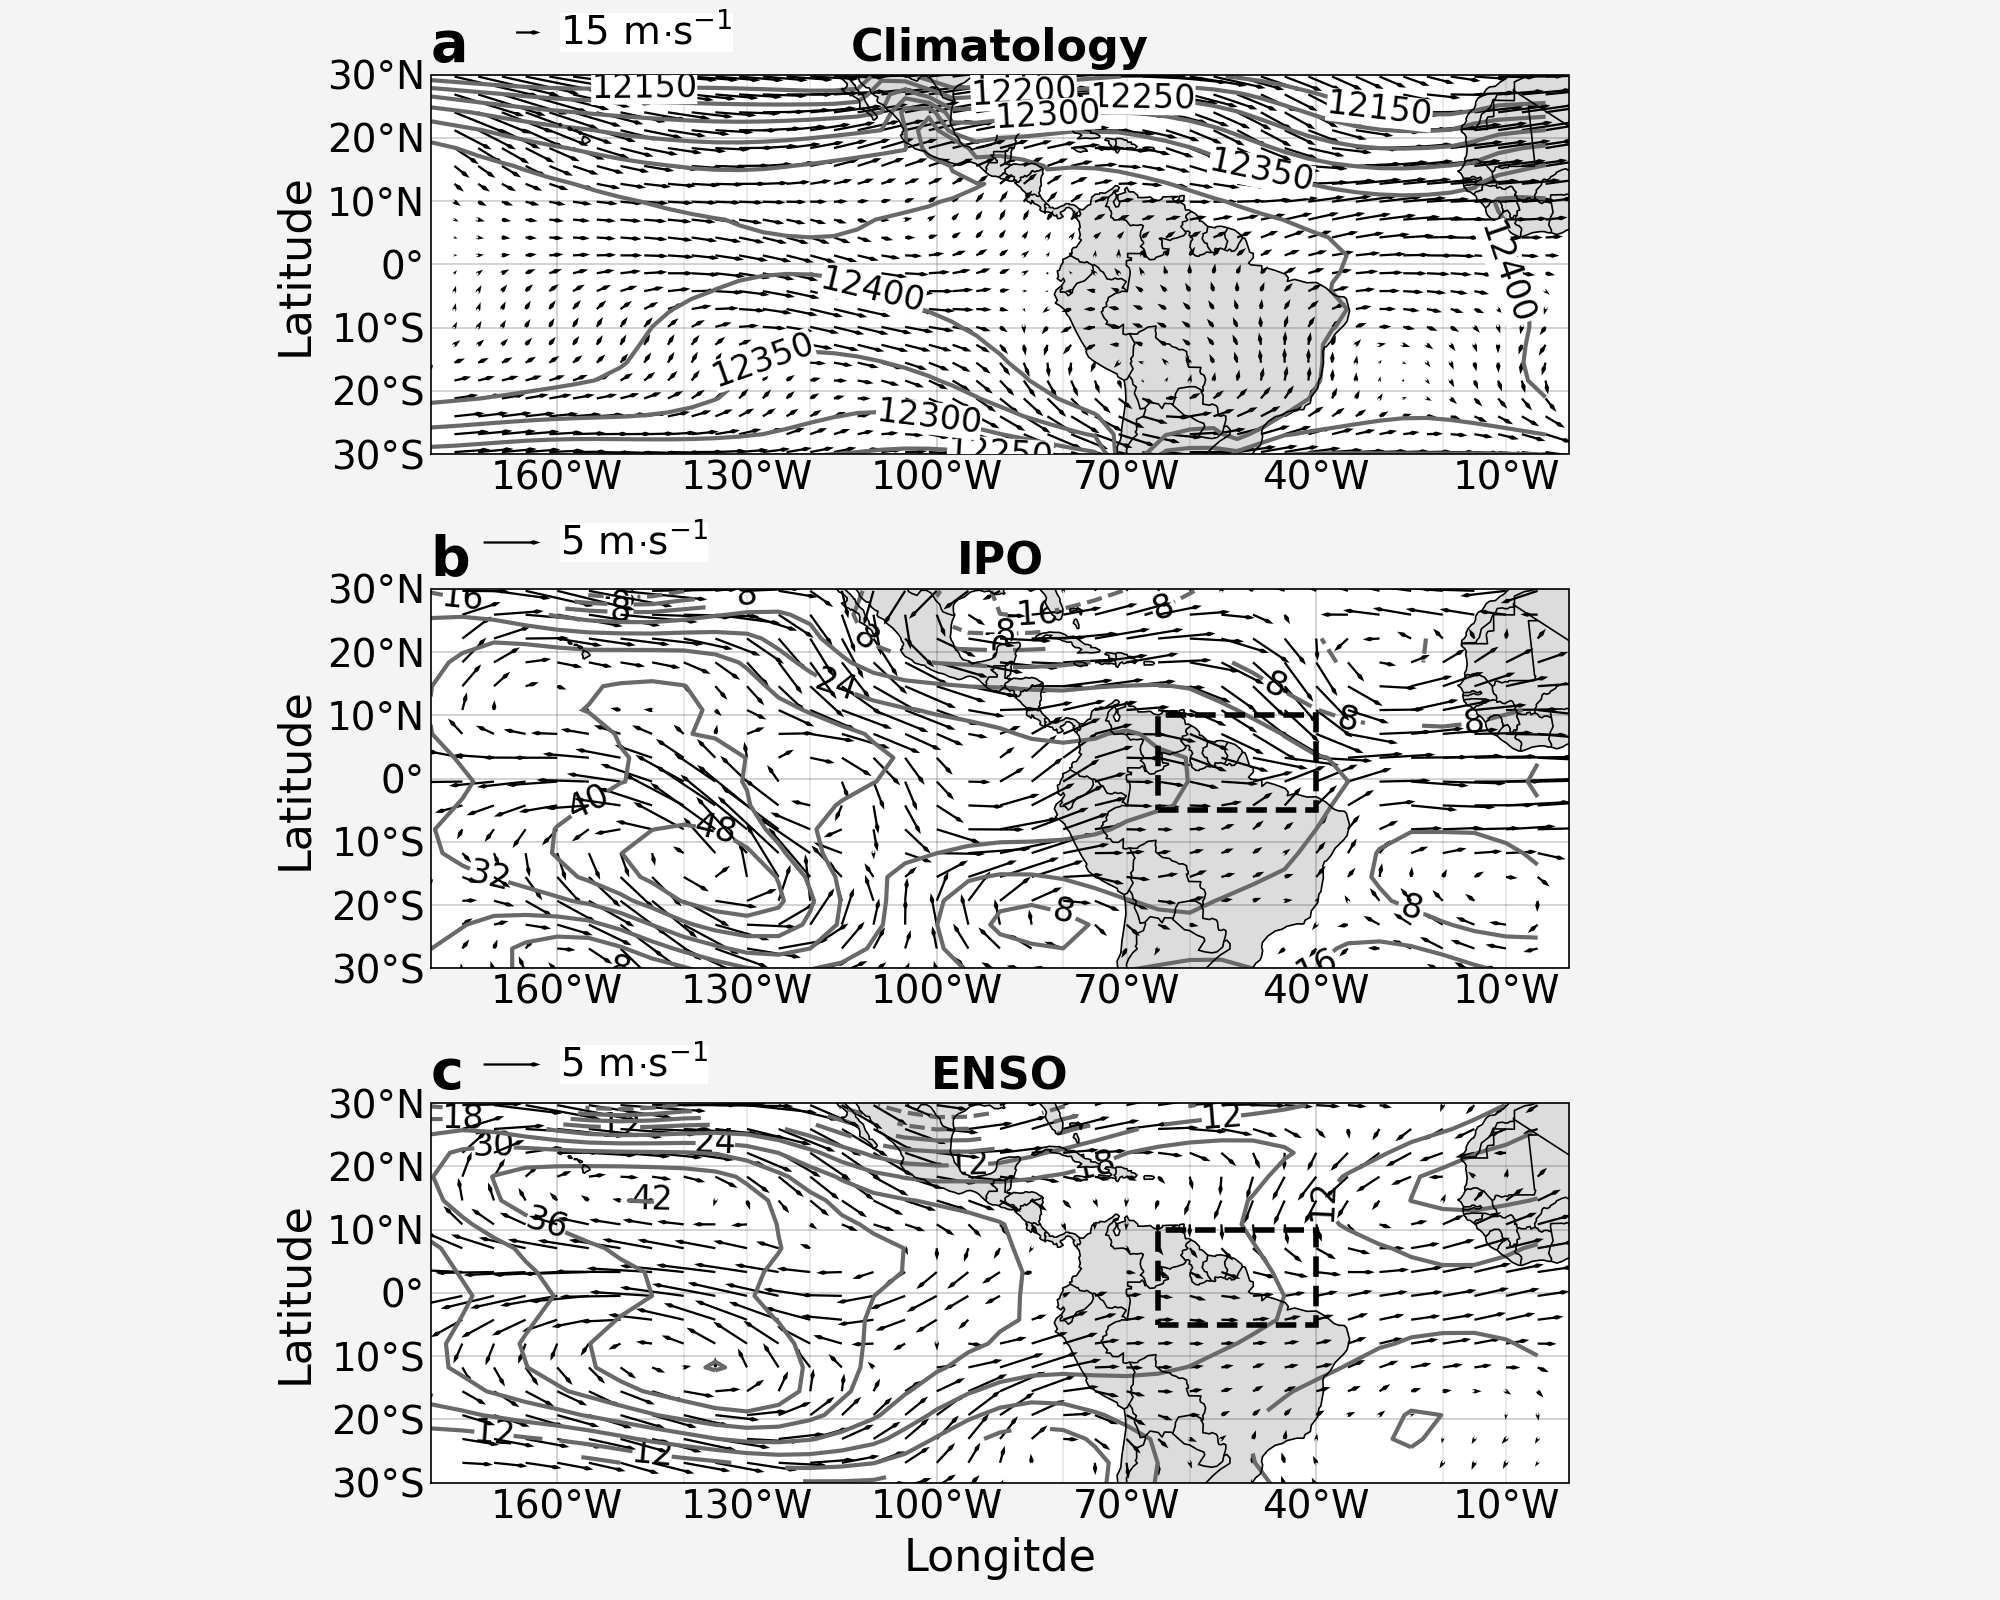

In [8]:
# regression of ENSO, IPO and upper/lower level winds
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 12})
pplt.rc['abc.size'] = 20

# ---------------
# Plot preamble
# ---------------

fig, axs = pplt.subplots(nrows=3, ncols=1, figsize=(10, 8), proj=('cyl'))
axs.format(
    land=True, labels=False, lonlines=20, latlines=10, abc='a', coast = True, borders = True, 
    landcolor = 'gainsboro',
#     gridminor=True, suptitle='DJF composites, average, warm and cold pdo anomaly years based on 1.0 (1.5) std dev in mod (prox)'
)
# axs.format(lonlim=(180,360), latlim=(-30,30), labels=True)

for ax in axs:
    ax.set_extent([-180,0,30,-30], crs=ccrs.PlateCarree())
    ax.set_xticks([-160, -130, -100, -70,  -40,  -10], crs=ccrs.PlateCarree())   
    ax.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    lon_fmt = LongitudeFormatter(number_format='.0f')
    lat_fmt = LatitudeFormatter(number_format='.0f')
    ax.yaxis.set_major_formatter(lat_fmt)
    ax.xaxis.set_major_formatter(lon_fmt)
    ax.set_ylabel('Latitude', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

axs[2].set_xlabel('Longitde', fontsize=16)

## ----
## climo
## -----

skip = 3
zlevs = [12150., 12200., 12250., 12300., 12350., 12400.]
uv200_climo = axs[0].quiver(lon[::skip],lat[::skip], climo[0][::skip,::skip], climo[1][::skip,::skip], 
                            scale=700, width=0.002, headwidth=2., headlength=3., color='k',zorder = 2,transform=ccrs.PlateCarree())
qk = plt.quiverkey(uv200_climo, 0.27, 0.98, 15.0,  r'$15 \,\, m \dot s^{-1}$', labelsep=0.1, 
                   labelpos='E', coordinates='figure', color = 'k', fontproperties={'size': 14}) #r'$5 \,\, \frac{m}{s}$'
t = qk.text.set_bbox(dict(facecolor='white', edgecolor='none', pad=0))
z200_clim = axs[0].contour(lon[::skip],lat[::skip], climo[2][::skip,::skip], colors='dimgrey', 
                           levels=zlevs, transform=ccrs.PlateCarree())
clim_clab = axs[0].clabel(z200_clim, zlevs, inline=True, fmt=fmt, colors='k', fontsize=12)
# axs[0].set_title('Climatological geopotential height and winds (200 hPa)')
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clim_clab]
axs[0].set_title('Climatology', fontsize=16, weight='bold')

## ----
## IPO regression with upper level winds
## -----
skip = 4
uv200_reg = axs[1].quiver(lon[::skip],lat[::skip], u_m_ipo[::skip,::skip], v_m_ipo[::skip,::skip], 
                            scale=100, width=0.002, headwidth=2., headlength=3., color='k',zorder = 2,transform=ccrs.PlateCarree())
qk1 = plt.quiverkey(uv200_reg, 0.27, 0.661, 5.0,  r'$5 \,\, m \dot s^{-1}$', labelsep=0.1,
                   labelpos='E', coordinates='figure', color = 'k', fontproperties={'size': 14}) #r'$5 \,\, \frac{m}{s}$'
t = qk1.text.set_bbox(dict(facecolor='white', edgecolor='none', pad=0))

z200_ipo = axs[1].contour(lon[::skip],lat[::skip], z_m_ipo[::skip,::skip], colors='dimgrey',                          transform=ccrs.PlateCarree())
ipo_clab = axs[1].clabel(z200_ipo, z200_ipo.levels, inline=True, fmt=fmt, colors='k', fontsize=12,zorder =0)
# axs[1].set_title('IPO regression against wind, geopotential height; 200 hPa')
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in ipo_clab]

convec_rec = axs[1].add_patch(patches.Rectangle(xy=[295, -5], width=25, height=15,
                            facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2.0, zorder=5,
                            transform=ccrs.PlateCarree()))
axs[1].set_title('IPO', fontsize=16, weight='bold')

## ----
## ENSO regression with upper level winds
## -----
skip = 4
uv200_reg = axs[2].quiver(lon[::skip],lat[::skip], u_m_enso[::skip,::skip], v_m_enso[::skip,::skip], 
                            scale=100, width=0.002, headwidth=2., headlength=3., color='k',zorder = 2,transform=ccrs.PlateCarree())
qk2 = plt.quiverkey(uv200_reg, 0.27, 0.335, 5.0,  r'$5 \,\, m \dot s^{-1}$', labelsep=0.1,
                   labelpos='E', coordinates='figure', color = 'k', fontproperties={'size': 14}) #r'$5 \,\, \frac{m}{s}$'
t = qk2.text.set_bbox(dict(facecolor='white', edgecolor='none', pad=0))
z200_enso = axs[2].contour(lon[::skip],lat[::skip], z_m_enso[::skip,::skip], colors='dimgrey',                          transform=ccrs.PlateCarree())
ens_clab = axs[2].clabel(z200_enso, z200_enso.levels[6:], inline=True, fmt=fmt, colors='k', fontsize=12,zorder =0)
# axs[2].set_title('ENSO regression against wind, geopotential height; 200 hPa')
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in ens_clab]

convec_rec = axs[2].add_patch(patches.Rectangle(xy=[295, -5], width=25, height=15,
                            facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2.0, zorder=5,
                            transform=ccrs.PlateCarree()))
axs[2].set_title('ENSO', fontsize=16, weight='bold')

# plt.savefig('/network/rit/home/ro553136/orrison/Plots/Pac_SAm/Fig7_ENSOIPO_u_v_z200_ClimReg.jpg',format='JPEG', dpi=300)
plt.show()